# Vanilla RNN

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import trange
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
import matplotlib.colors as mcolors

### tSNE Plotting function

In [5]:
def plot_tsne(hidden_states, grid_positions, n_back, step_hidden=40, step_pos=40):
    
    assert step_hidden != 0, "Step zero has trivial representation."

    # Convert (x, y) to grid ID if needed
    if isinstance(grid_positions[0], (tuple, list, np.ndarray)) and len(grid_positions[0]) == 2:
        # It's (x, y), convert to flat ID assuming 5x5 grid
        pos_ids = np.array([x * 5 + y for x, y in grid_positions])
    else:
        # Already flat IDs
        pos_ids = np.array(grid_positions)

    # Run t-SNE
    np.random.seed(0)
    transformed = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=SEED).fit_transform(hidden_states)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1], hue=pos_ids.astype(str))
    
    plt.title(f"t-SNE of Hidden States at step {step_hidden}\n colored by grid position at step {step_pos} (n={n_back})")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
   
   # Reorder legend and place it outside the plot
    handles, labels = plt.gca().get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda x: int(x[0])))  # sort numerically
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', title="Grid Pos ID")


    plt.tight_layout()
    plt.show()

### RNN implementation


=== Training N=0 ===


/Users/saraasadi/miniforge3/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
Training N=0: 100%|██████████| 50/50 [01:39<00:00,  1.99s/it]


Evaluating and extracting hidden states for N=0...
N=0 Final Accuracy: 1.0000
Running t-SNE...


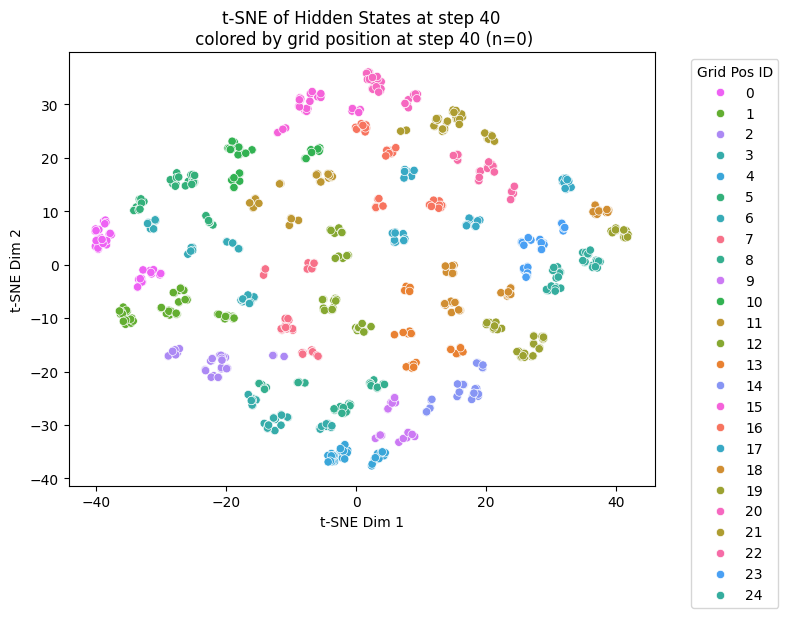


=== Training N=1 ===


/Users/saraasadi/miniforge3/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
Training N=1: 100%|██████████| 50/50 [01:43<00:00,  2.06s/it]


N=1 Final Accuracy: 1.0000

=== Training N=2 ===


Training N=2: 100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


N=2 Final Accuracy: 1.0000

=== Training N=3 ===


Training N=3: 100%|██████████| 50/50 [01:41<00:00,  2.04s/it]


N=3 Final Accuracy: 1.0000

=== Training N=4 ===


Training N=4: 100%|██████████| 50/50 [01:42<00:00,  2.04s/it]


N=4 Final Accuracy: 1.0000

=== Training N=5 ===


Training N=5: 100%|██████████| 50/50 [01:40<00:00,  2.01s/it]


N=5 Final Accuracy: 1.0000

=== Training N=6 ===


Training N=6: 100%|██████████| 50/50 [01:41<00:00,  2.02s/it]


N=6 Final Accuracy: 0.9902

=== Training N=7 ===


Training N=7: 100%|██████████| 50/50 [01:40<00:00,  2.01s/it]


N=7 Final Accuracy: 0.9899

=== Training N=8 ===


Training N=8: 100%|██████████| 50/50 [01:40<00:00,  2.01s/it]


N=8 Final Accuracy: 0.8969

=== Training N=9 ===


Training N=9: 100%|██████████| 50/50 [01:40<00:00,  2.01s/it]


N=9 Final Accuracy: 0.8245

=== Training N=10 ===


Training N=10: 100%|██████████| 50/50 [01:40<00:00,  2.01s/it]


N=10 Final Accuracy: 0.7238


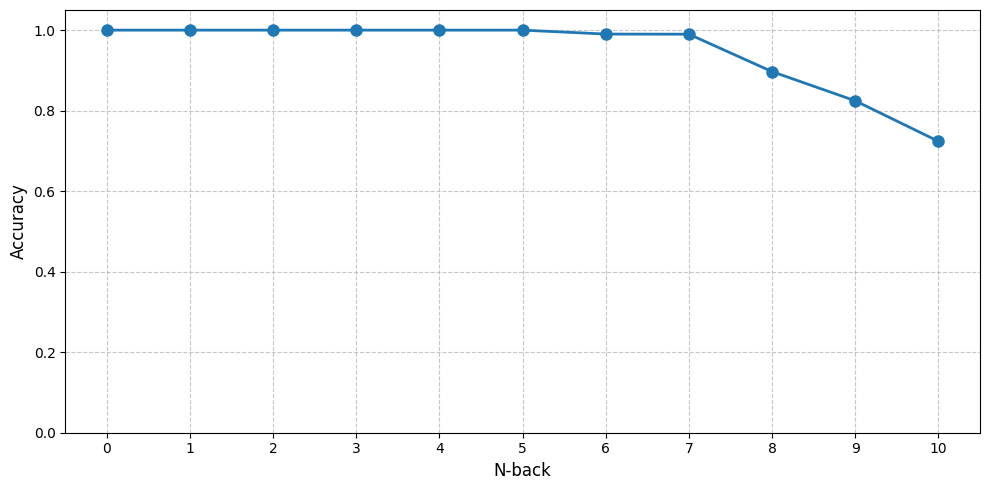

In [6]:
from n_back_spatial_task import (  
    create_n_back_dataset,
    NBackDataset as ItaloNBackDataset
)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)  

#--Configuration--
GRID_SIZE = np.array([5, 5], dtype=int)  
HIDDEN_SIZE = 256
INPUT_SIZE = 4 
OUTPUT_SIZE = GRID_SIZE[0] * GRID_SIZE[1] 
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  
SEQ_LENGTH = 50  
BATCH_SIZE = 100
LEARNING_RATE = 0.0005
EPOCHS = 50
BOUNDARY = 'strict'  

class NBackDataset(ItaloNBackDataset):  # Inherit from Italo's class
    def __init__(self, num_samples, n_back):
        # Using Italo's create_n_back_dataset function
        dataset = create_n_back_dataset(
            num_samples=num_samples,
            n=n_back,
            max_length=SEQ_LENGTH,
            grid_size=GRID_SIZE,
            boundary=BOUNDARY
        )
        super().__init__(dataset.x, dataset.y)

class NBackRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.RNN = nn.RNN(
            input_size=4,
            hidden_size=HIDDEN_SIZE,
            num_layers=1,
            batch_first=True,
            dropout=0.2
        )
        self.fc = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
    
        self.h0 = nn.Parameter(torch.randn(1, 1, HIDDEN_SIZE) * 0.05)
        #self.c0 = nn.Parameter(torch.randn(1, 1, HIDDEN_SIZE) * 0.05) #not useful for Vanilla RNNs (cell state)
        
    def forward(self, x, batch_size):
        x = F.one_hot(x, num_classes=4).float().to(DEVICE)
        h0 = self.h0.expand(1, batch_size, -1).contiguous()
        #c0 = self.c0.expand(1, batch_size, -1).contiguous() #uncomment if using LSTM
        out, _ = self.RNN(x, h0) # if LSTM, use touple (H0, C0) instead
        return self.fc(out)

class NBackTrainer:
    def __init__(self, n_back):
        self.n_back = n_back
        self.model = NBackRNN().to(DEVICE)
        self.optimizer = optim.AdamW(self.model.parameters(), lr=LEARNING_RATE)
        self.criterion = nn.CrossEntropyLoss()
        
    def train(self, epochs=EPOCHS):
        train_loader = DataLoader(
            NBackDataset(10_000, self.n_back),
            batch_size=BATCH_SIZE,
            shuffle=True
        )
        
        self.model.train()
        for epoch in trange(epochs, desc=f"Training N={self.n_back}"):
            total_loss = 0
            for actions, targets in train_loader:
                actions, targets = actions.to(DEVICE), targets.to(DEVICE)
                batch_size = actions.size(0)
                
                self.optimizer.zero_grad()
                logits = self.model(actions, batch_size)
                
                loss = self.criterion(
                    logits[:, self.n_back:].reshape(-1, OUTPUT_SIZE),  # Skip first N logits
                    targets[:, 1:].reshape(-1)  # Skip initial position in targets (align x and y)
                    )
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
                total_loss += loss.item()
    
    def evaluate(self, test_samples=1_000, return_hidden_states=False, time_step=None):
        test_loader = DataLoader(
            NBackDataset(test_samples, self.n_back),
            batch_size=BATCH_SIZE
        )
        
        self.model.eval()
        correct = total = 0
        all_hidden_states = []
        all_labels = []

        with torch.no_grad():
            for actions, targets in test_loader:
                actions, targets = actions.to(DEVICE), targets.to(DEVICE)
                batch_size = actions.size(0)

                # Get one-hot and hidden outputs
                one_hot = F.one_hot(actions, num_classes=4).float()
                h0 = self.model.h0.expand(1, batch_size, -1).contiguous()
                RNN_out, _ = self.model.RNN(one_hot, (h0))

                logits = self.model.fc(RNN_out)
                preds = logits[:, self.n_back:].argmax(-1)
                tgts = targets[:, 1:]  # Remove the initial dummy target
                correct += (preds == tgts).sum().item()
                total += tgts.numel()

                if return_hidden_states and time_step is not None and time_step < SEQ_LENGTH:
                    valid_batch_idx = (targets.shape[1] > time_step + 1)
                    for i in range(batch_size):
                        if valid_batch_idx:
                            hidden = RNN_out[i, time_step, :].cpu().numpy()
                            label = targets[i, time_step + 1].item()
                            all_hidden_states.append(hidden)
                            all_labels.append(label)

        acc = correct / total if total > 0 else 0
        if return_hidden_states:
            return acc, np.array(all_hidden_states), np.array(all_labels)
        return acc

def run_experiment(max_n=10):
    accuracies = []
    for N in range(max_n + 1):
        print(f"\n=== Training N={N} ===")
        trainer = NBackTrainer(N)
        trainer.train()

        # Evaluate 3 times for stability
        if N in [0]:  # For selected N, extract hidden states too
            print(f"Evaluating and extracting hidden states for N={N}...")
            acc, hidden_states, labels = trainer.evaluate(return_hidden_states=True, time_step=40)
            accuracies.append(acc)
            print(f"N={N} Final Accuracy: {acc:.4f}")
            print("Running t-SNE...")
            plot_tsne(hidden_states, labels, N)
        else:
            eval_acc = np.mean([trainer.evaluate() for _ in range(3)])
            accuracies.append(eval_acc)
            print(f"N={N} Final Accuracy: {eval_acc:.4f}")
            
    return accuracies

# Run experiment
accuracies = run_experiment()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(len(accuracies)), accuracies, marker='o', linewidth=2, markersize=8)
plt.xlabel("N-back", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(range(len(accuracies)))
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()